In [1]:
from utils.load import load_mnist
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from modules.couplingfno import CouplingLayerFNO

In [2]:
def bilinear_seg(x, modes, step, device):
    x = x.to(device)
    pyramid = [F.interpolate(x, size=(modes, modes), mode='bilinear')]
    B, C, H, W = x.shape
    for i in range((H - modes)//step - 1):
        pyramid.append(F.interpolate(x, size=(modes+(i+1)*step, modes+(i+1)*step), mode='bilinear'))
    pyramid.append(x)
    residual = []
    for i, j in enumerate(pyramid[1:]):
        residual.append(j - F.interpolate(pyramid[i], size=(modes+(i+1)*step, modes+(i+1)*step), mode='bilinear'))
    residual.insert(0, pyramid[0])
    return residual, pyramid

In [3]:
train, test = load_mnist(64, shape_setting=[[28, 1]])

In [4]:
batch = next(iter(train))

In [5]:
x = batch[0]

In [6]:
res, pyr = bilinear_seg(x, 16, 2, 'cuda')

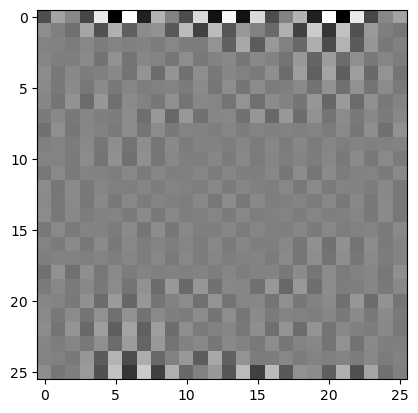

In [7]:
plt.imshow(torch.fft.fft2(res[5]).real[0, 0].cpu().detach().numpy(), cmap='gray')

In [8]:
x_f = torch.fft.rfft2(x, dim=(-2,-1))
size = x.shape[-2]
x_left = x_f.clone()
x_right = x_f.clone()
x_left[..., size//2:, :] = 0
x_right[..., :size//2, :] = 0

In [9]:
x_l = torch.fft.irfft2(x_left, dim=(-2,-1))
x_r = torch.fft.irfft2(x_right, dim=(-2,-1))

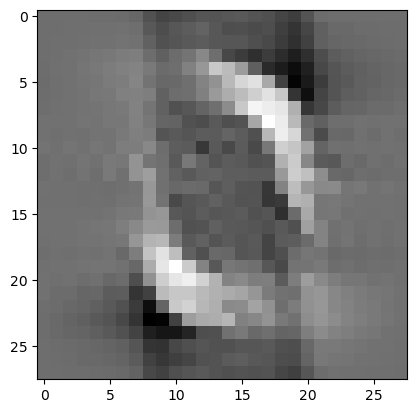

In [10]:
plt.imshow(x_r[1, 0].cpu().detach().numpy(), cmap='gray')

In [11]:
model = CouplingLayerFNO(True, 1, 16, 2, 2, 64).to('cuda')

In [12]:
x = x.to('cuda')

In [13]:
condition = torch.ones_like(x).to('cuda')

In [14]:
z, ldj = model(x, torch.Tensor([64]).to('cuda'), condition=condition)

torch.Size([64, 28, 28, 2]) torch.Size([64, 28, 28, 2]) torch.Size([64, 28, 28, 1])


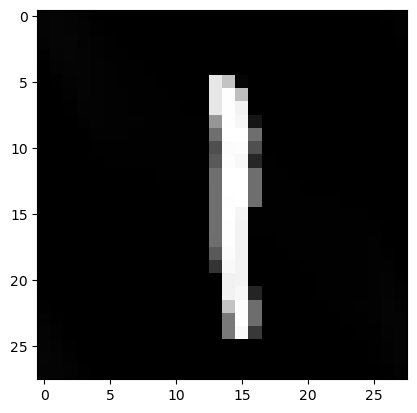

In [15]:
plt.imshow(z[0, 0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=255)

In [16]:
orig, ldj = model(z, torch.Tensor([64]).to('cuda'), condition=condition, sample=True)

torch.Size([64, 28, 28, 2]) torch.Size([64, 28, 28, 2]) torch.Size([64, 28, 28, 1])


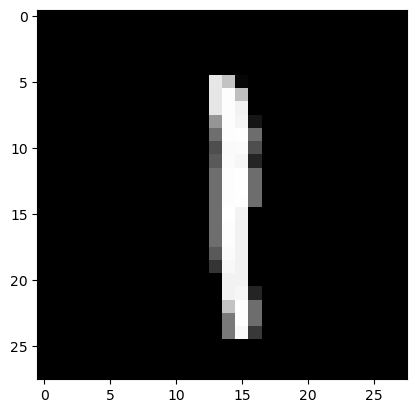

In [17]:
plt.imshow(orig[0, 0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=255)

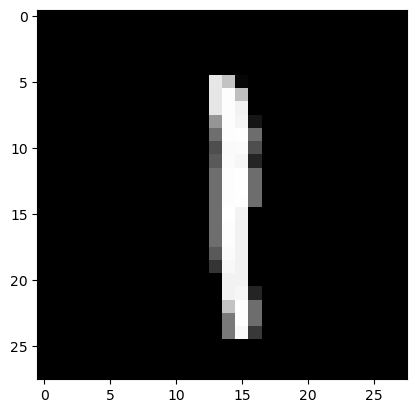

In [18]:
plt.imshow(x[0, 0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=255)